# Thomas Fire Impact: Air Quality Index Trends and False Imagery Assessment

## Author: Diana Navarro

https://github.com/dianaxnav/ready-repo

# About

## Purpose 

In 2017, Santa Barbara and Ventura county suffered the 7th largest wildfire in the history of California. Almost 300,000 acres were burned and caused more than 150 million in damages across both counties. The purpose of this repsoitiory is to show the the damages of the Thomas fire in two different ways. We will plot the trend of AQI over a 5 day average to see how it affected the air quality in December of 2017. Next we will map out Santa Barbara County and layer over the Thomas Fire perimeter showing the extent of the land that was burned.  

## Highlights of Analysis 
1. Download data
2. Concatenate datasets
3. Data Tidying
4. Indexing
5. Plotting

## Dataset Description 

#### Air Quality Index 
To properly represent this data, we will be plotting the trend of Air Quality Index (AQI) data. This dat is provided by the US Environmental Protection Agency. AQI is the EPA's index for reporting air quality on a scale from 0 ot 500, with O representing a healthy air quality and 500 a hazardous air quality. 


#### False Color Imagery
In order to create the false imagery map, we will need to use two datasets here. One of the datasets is from the Landsat 8 Satellite and provides a collection of bands from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data. In order to outline the Thomas Fire dataset within the spatial data, we will access a shape file from the California Department of Forestry and Fire protection. This file shows us the perimeters of the Thomas Fire in 2017. 

## References to Datasets 

AirNow. (2021b). Air Quality Index (AQI) Basics. Retrieved from www.airnow.gov website: https://www.airnow.gov/aqi/aqi-basics/ 

Wikipedia Contributors. (2019, October 6). Thomas Fire. Retrieved from Wikipedia website: https://en.wikipedia.org/wiki/Thomas_Fire

California Fire Perimeters (all). (n.d.). Retrieved November 29, 2023, from gis.data.ca.gov website: https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about

USGS. (n.d.). What are the band designations for the Landsat satellites? | U.S. Geological Survey. Retrieved from www.usgs.gov website: https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites


## 1. Importing Data

Let's load all the libraries we will potentially use:

In [1]:
#Import all necessary libraries 
import os
import numpy as np

import geopandas as gpd
import xarray as xr
import rioxarray as rioxr

from shapely import Point
import matplotlib.pyplot as plt
import pandas as pd
from shapely import box
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

**Now lets load all our proper datasets:**
 
AQI Data can be accessed through the following steps: 
 1. Go to EPA's website on Air Quality Data Collected at Outdoor Monitors Across the US.
     (https://www.epa.gov/outdoor-air-quality-data)
 2. Under "Download Data" click on "Pre-generated Data Files"
 3. Click on "Tables of Daily AQI"
 4. Copy the URL to the 2017 Daily AQI by County zip file daily_aqi_by_county_2017.zip
 5. In the next code cell read in the data from the URL using the `pd.read_csv` function and store it as `aqi_17`. 
 6. In the same cell, read in the data for the 2018 Daily AQI by County zip file and store it as `aqi_18`.
     
Landsat Data is stored in the data folder under 'landsat8-2018-01-26-sb-simplified.nc'. We will store this as `landsat`.

Cal Fire data is store in the folder 'California_Fire_Perimeters_2017'. We will store this as `cal_fire`.


In [3]:
#read in the data using read csv function and store it
aqi_17 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip")

aqi_18 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip")

# load landsat nc file (1st dataset)
landsat1 = os.path.join(os.getcwd(),'data','landsat8-2018-01-26-sb-simplified.nc')
landsat = rioxr.open_rasterio(landsat1)

#load ca fire data using gpd 
cal_fire = gpd.read_file('data/California_Fire_Perimeters_2017')

## 2. Data Exploration

In the next couple cells, we will explore the dataset in order to better understand what we want to do with the data and how we would like to plot it.  

In [5]:
#use the head function to take a look at the first five rows of the aqi data
aqi_17.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2017-01-01,21,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2017-01-04,22,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2017-01-10,19,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2017-01-13,30,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2017-01-16,16,Good,PM2.5,01-003-0010,1


In [6]:
#use the head function to take a look at the first five rows
aqi_18.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2018-01-02,32,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2018-01-05,34,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2018-01-08,15,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2018-01-11,19,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2018-01-14,25,Good,PM2.5,01-003-0010,1


In [11]:
#check out the data types of all cols in the aqi datasets
print(aqi_17.dtypes)

print(aqi_18.dtypes)

State Name                   object
county Name                  object
State Code                    int64
County Code                   int64
Date                         object
AQI                           int64
Category                     object
Defining Parameter           object
Defining Site                object
Number of Sites Reporting     int64
dtype: object
State Name                   object
county Name                  object
State Code                    int64
County Code                   int64
Date                         object
AQI                           int64
Category                     object
Defining Parameter           object
Defining Site                object
Number of Sites Reporting     int64
dtype: object


AQI dataset is something similar to what we've worked with before. Now let's check on our spatial data.

In [7]:
#lets take a look at the landsat and cal_fire data and see what type they are 
print(type(landsat))

print(type(cal_fire))

<class 'xarray.core.dataset.Dataset'>
<class 'geopandas.geodataframe.GeoDataFrame'>


In [13]:
#take a look at the landsat data
landsat

<xarray.Dataset>
Dimensions:      (y: 731, x: 870, band: 1)
Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Data variables:
    red          (band, y, x) float64 ...
    green        (band, y, x) float64 ...
    blue         (band, y, x) float64 ...
    nir08        (band, y, x) float64 ...
    swir22       (band, y, x) float64 ...

In [9]:
#take a look at the first five rows of our cal_fire geodataframe
cal_fire.head()

,index,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,...,GIS_ACRES,COMMENTS,COMPLEX_NA,COMPLEX_IN,IRWINID,FIRE_NUM,DECADES,SHAPE_Leng,SHAPE_Area,geometry
0,19836,41429,2017,CA,CCO,VNC,BROOK,00042450,2017-05-23,2017-05-24,...,10.043819,per walked track,None,None,None,None,2010,1246.055781,59473.666651,"POLYGON ((-13229812.974 4046876.486, -13229786..."
1,19837,41430,2017,CA,CCO,VNC,PACIFIC,00075307,2017-09-09,2017-09-09,...,1.190109,Final Walked track. Small spot to the north east,None,None,None,None,2010,561.418202,7081.369481,"POLYGON ((-13286872.985 4074523.355, -13286895..."
2,19838,41431,2017,CA,CCO,VNC,GRADE,00054660,2017-07-04,2017-07-05,...,47.194027,None,None,None,None,None,2010,2587.259697,279911.825212,"POLYGON ((-13244637.580 4056332.530, -13244620..."
3,19839,41432,2017,CA,CCO,VNC,PACIFICA,00051791,2017-06-24,2017-06-24,...,1.158548,GPS track,None,None,None,None,2010,501.178102,6859.664843,"POLYGON ((-13229521.754 4046254.111, -13229510..."
4,19840,41433,2017,CA,CCO,VNC,MONTVIEW,00040196,2017-05-15,2017-05-15,...,2.893327,Rough per description. waiting for walked GPS...,None,None,None,None,2010,484.388887,17133.006159,"POLYGON ((-13229663.036 4046858.853, -13229667..."


Now that we have checked out and explored all our datasets, lets work on tidying up the dataset and making updates to plot! 

## 3. Analysis

In this next section lets work on  AQI data first. We want to join both datasets together into one data frame.

To do this we will need put `[aqi_17, aqi_18]` as the input of `pd.concat()` and store the output as  `aqi`.

After you have concatenated both of these datasets together, take a look at the data frame after. Do you notice anything odd?

In [14]:
#store the the output and use the concat function to join
aqi = pd.concat([aqi_17, aqi_18])

#take a look at the data frame
aqi

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2017-01-01,21,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2017-01-04,22,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2017-01-10,19,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2017-01-13,30,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2017-01-16,16,Good,PM2.5,01-003-0010,1
...,...,...,...,...,...,...,...,...,...,...
327532,Wyoming,Weston,56,45,2018-12-27,36,Good,Ozone,56-045-0003,1
327533,Wyoming,Weston,56,45,2018-12-28,35,Good,Ozone,56-045-0003,1
327534,Wyoming,Weston,56,45,2018-12-29,35,Good,Ozone,56-045-0003,1
327535,Wyoming,Weston,56,45,2018-12-30,31,Good,Ozone,56-045-0003,1


When we concatenate like this, without any extra parameters for `pd.concat()` the indices for the two dataframes are just "glued together", the index of the resulting dataframe is not updated to start from 0. Notice the index of `aqi` ends in 327536 while it has 654338 rows.

### 3a. Data Tidying - AQI

To make it easier on us to work with the data. We are going to make a few updates to the frame.

1. Take a look at the column names.
2. Re-assign the column names to all lower case. 
3. Replace the spaces in between with '_'. 

In [15]:
# initial column names: notice caps and spaces (difficult to work with!)
print(aqi.columns, '\n')

# re-assign the column names - .str.lower() makes them lower case
aqi.columns = aqi.columns.str.lower()
print(aqi.columns, '\n')

#  re-assign the column names again - .str.replace(' ','_') replaces the space for _
aqi.columns = aqi.columns.str.replace(' ','_')
print(aqi.columns)

Index(['State Name', 'county Name', 'State Code', 'County Code', 'Date', 'AQI',
       'Category', 'Defining Parameter', 'Defining Site',
       'Number of Sites Reporting'],
      dtype='object') 

Index(['state name', 'county name', 'state code', 'county code', 'date', 'aqi',
       'category', 'defining parameter', 'defining site',
       'number of sites reporting'],
      dtype='object') 

Index(['state_name', 'county_name', 'state_code', 'county_code', 'date', 'aqi',
       'category', 'defining_parameter', 'defining_site',
       'number_of_sites_reporting'],
      dtype='object')


### 3b. Data selection - AQI

In the next cell we would like to select only data from Santa Barbara and store this as a new variable to work with. Then we are going to drop some unnecessary columns to make the dataframe easier to work with. 

Then lets take a look at the data! 

In [16]:
#select santa barbara data from county col and store the output 
aqi_sb = aqi[aqi.county_name == 'Santa Barbara']

#remove the cols --don't store this-- keep it as an object
aqi_sb = aqi_sb.drop(columns = ["state_name", "county_name", "state_code", "county_code"])

#check out the dtypes of each of the cols 
aqi_sb.dtypes

date                         object
aqi                           int64
category                     object
defining_parameter           object
defining_site                object
number_of_sites_reporting     int64
dtype: object

This data frame is much smaller and easier to handle.

### 3c. Updates - AQI

In this sectionw we want to switch our date column to a date time object. We can do so by using `pd.to_datetime()`. 

Then we want to set the index of the dataframe to be the date column to make it easier to plot!

In [20]:
#update the date col to be a datetime object
aqi_sb['date'] = pd.to_datetime(aqi_sb.date)

#set the index to date col
aqi_sb.set_index('date', inplace = True)

Now, lets make sure the date column was updated properly by accessing the index of aqi_sb by running aqi_sb.index. Add in a comment what is the data type (dtype) of the index.

In [21]:
# check it updated the index 
aqi_sb.index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=730, freq=None)

We know this worked because the object now says `datetime64`.

Now that we have updated that, lets change the data to include rolling window calculations on a 5-day basis based on the mean.

In [23]:
# rolling() is a method for pandas.series that provides rolling window calculations
# the parameter '5D' indicates we want the window to be 5 days
# this indicates we want the mean over each window
# and we get a pd.Series as ouput
aqi_sb.aqi.rolling('5D').mean()

date
2017-01-01    39.000000
2017-01-02    37.500000
2017-01-03    48.666667
2017-01-04    45.000000
2017-01-05    43.400000
                ...    
2018-12-27    38.600000
2018-12-28    38.600000
2018-12-29    38.200000
2018-12-30    37.800000
2018-12-31    38.400000
Name: aqi, Length: 730, dtype: float64

Now lets add the function as a column to our `aqi_sb` dataframe.

In [25]:
#add the mean of the AQI over a 5 day rolling window using `rolling` function 
#-dont store the object
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling('5D').mean()

#take a look at the dateframe to make sure it was added
aqi_sb

,aqi,category,defining_parameter,defining_site,number_of_sites_reporting,five_day_average
date,,,,,,
2017-01-01,39,Good,Ozone,06-083-4003,12,39.000000
2017-01-02,36,Good,Ozone,06-083-4003,11,37.500000
2017-01-03,71,Moderate,PM10,06-083-4003,12,48.666667
2017-01-04,34,Good,Ozone,06-083-4003,13,45.000000
2017-01-05,37,Good,Ozone,06-083-4003,12,43.400000
...,...,...,...,...,...,...
2018-12-27,37,Good,Ozone,06-083-1025,11,38.600000
2018-12-28,39,Good,Ozone,06-083-1021,12,38.600000
2018-12-29,39,Good,Ozone,06-083-1021,12,38.200000


Great! We are now finished with tidying up the AQI data. Time to tackle the `landsat` and `cal_fire` data.

### 3d. Data Tidying - Landsat

If you notice in the landsat data above during the exploration, `landsat` contains a single band. However, we don't need this so lets drop it.

In [27]:
#lets drop the band using `squeeze()` 
landsat = landsat.squeeze().drop('band')

#take a look at the dataset
landsat

<xarray.Dataset>
Dimensions:      (y: 731, x: 870)
Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
    spatial_ref  int64 0
Data variables:
    red          (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    green        (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    blue         (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    nir08        (y, x) float64 ...
    swir22       (y, x) float64 ...

## 4. Geographical context of data

### 4a. True Color Image exploration 

For this section, lets not store these variables. 

Select the red, green and blue variables (in that order) of the xarray.Dataset, convert it to a numpy.array using the `to_array()` method, and then use `.plot.imshow()` to create an RGB image with the data. (There will be a warning)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


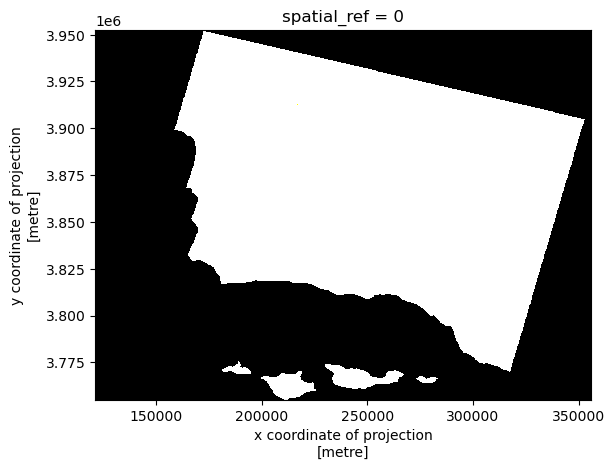

In [32]:
# select red, green, and blue variables and use to array and plot
landsat[['red', 'green', 'blue']].to_array().plot.imshow()

Adjust the scale used for plotting the bands to get a true color image. 
Check the `robust` parameter (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)
The issue here is the clouds: their RGB values are outliers and cause the other values to be squished when plotting. 

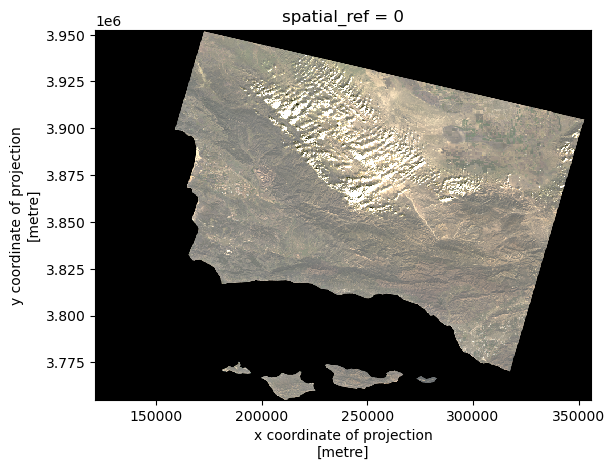

In [33]:
# include robust = true this time to print the image
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust = True)

### 4b. False Color Image Exploration

Create a false color image by plotting the short-wave infrared (swir22), near-infrared, and red variables (in that order).

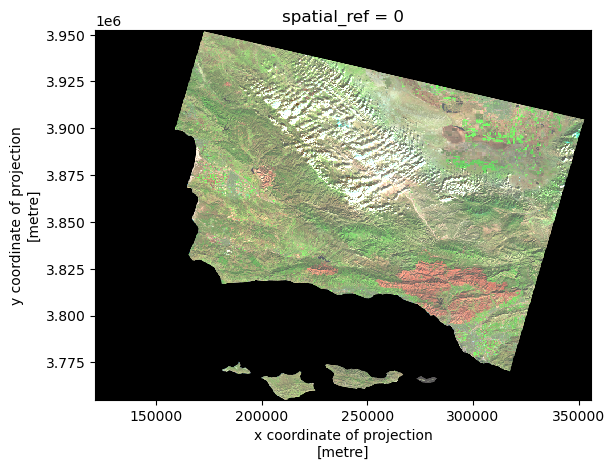

In [30]:
#create false imagery and call the variables
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)

### 4c. Update the spatial data

In this section, lets update the rest of our fire perimeter data (`cal_fire`).

In [34]:
#check to see if the crs matches
cal_fire.crs == landsat.rio.crs

False

It doesn't match so lets change the data crs. 

In [35]:
# Set the new CRS to make it equal to landsat
cal_fire = cal_fire.to_crs(landsat.rio.crs)

In [36]:
#check to make sure the crs updated
cal_fire.crs == landsat.rio.crs

True

It worked!

One last thing: Let's select the data from just the Thomas Fire.

In [38]:
#select thomas fire data only to plot it 
thomas_fire = cal_fire[cal_fire['FIRE_NAME'] == 'THOMAS']

## 5. Final Output 

### 5a. Daily AQI and 5-day Average

Let's make a line plot showing both the daily AQI and the 5-day average (5-day average on top of the AQI). Then let's update the title and colors of the graph. Can you see the AQI going up during the Thomas Fire in December 2017?

<AxesSubplot:title={'center':'Daily AQI and 5-day average'}, xlabel='Date', ylabel='AQI and Mean average(5-day period)'>

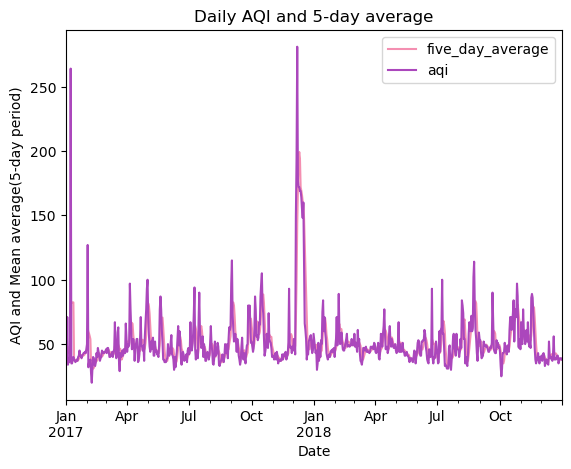

In [40]:
#it already knows to plot the date index so no need to call x
aqi_sb.plot(y=['five_day_average', 'aqi'], #call the y values 
        title = 'Daily AQI and 5-day average',
        xlabel='Date',
        ylabel='AQI and Mean average(5-day period)',  #label      
        color = {'five_day_average':'#F48FB1',
                 'aqi': '#AB47BC' #customize color
                 }
           )

**In the graph you could see the spike of aqi right in December 2017 when the Thomas fire occured, where it peaks just above 250.**

### 5b. Thomas Fire in Santa Barbara County

Let's create a map showing the shortwave infrared/nir/red false color image together with the Thomas fire perimeter.  

Text(0.5, 1.0, 'Thomas Fire in Santa Barbara County')

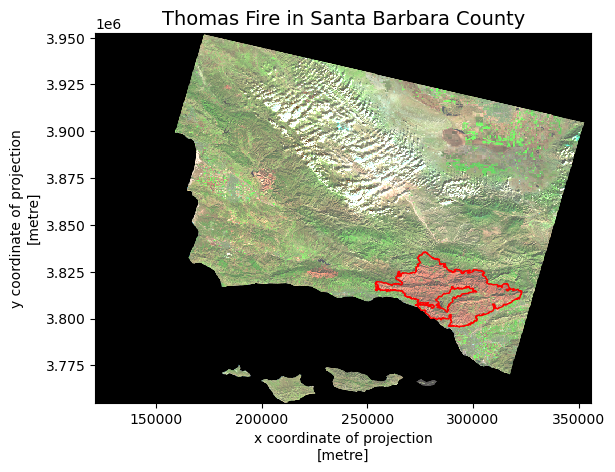

In [43]:
#create false imagery and call the variables
fig, ax = plt.subplots()
thomas_fire.plot(ax = ax, 
                 color = "None",
                edgecolor = "red")

#plot the show the data 
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)

#set the title of the map 
ax.set_title('Thomas Fire in Santa Barbara County', fontsize = 14)